In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import make_quantiles

sns.set_style('whitegrid')

c:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
plt.rcParams["pdf.fonttype"] = 42

In [3]:
exts = ['pdf', 'svg']

In [4]:
color_map = {
    '1.5C': 'AR6-C1',
    '2C': 'AR6-C3',
    'Current Policies': 'AR6-IP-CurPol',
}
pyam.run_control().update({'color': {'model': color_map}})

# Load Data

In [5]:
data_path = pathlib.Path('../data')
paper_prefix = '10.5281_zenodo.10158920_gidden_et_al_2023_ar6_reanalysis'

In [6]:
df = pyam.IamDataFrame(pd.concat([
    pd.read_csv(data_path / f'{paper_prefix}_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
]))

In [7]:
df.load_meta(data_path / f'{paper_prefix}_meta.csv')

[WARNING] 13:10:54 - pyam.core: No meta indicators for the following scenarios:
         model                scenario
0  AIM/CGE 2.0  ADVANCE_2020_1.5C-2100
1  AIM/CGE 2.0      ADVANCE_2020_Med2C
2  AIM/CGE 2.0       ADVANCE_2020_WB2C
3  AIM/CGE 2.0      ADVANCE_2030_Med2C
4  AIM/CGE 2.0  ADVANCE_2030_Price1.5C
...
[INFO] 13:10:54 - pyam.core: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [8]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C', 'Current Policies': 'Current Policies'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)
df.set_meta(
    'Current Policies', name='Temperature',
    index=df.meta.query("Policy_category_name == 'P1b: Current policies'").index
)

# CDR Bar Chart

In [9]:
df.add(
    a='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    b='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
    name='AR6 Reanalysis|OSCARv3.2|CDR',
    append=True, ignore_units='Mt CO2/yr',
)

In [10]:
def make_sequestration_plot_data(df, variables, categories_to_temp, years=[2030, 2050]):
    # pyam version of quantile data
    data = pyam.concat(
        [
            (
                df.filter(region="World", variable=variable)
                .filter(Category=category)
                .compute.quantiles((0.25, 0.5, 0.75))
                .rename(model={"Quantiles": temp})
            )
            for (category, temp), variable in itertools.product(
                categories_to_temp.items(), variables
            )
        ]
    )

    # data ready for plotting
    pdata = (
        data.filter(year=years)
        .as_pandas(meta_cols=False)
        .assign(index=lambda x: x.year.astype(str) + " " + x.model)
        .drop(columns=["region", "unit", "year", "model"])
        .set_index(["index", "scenario", "variable"])["value"]
        .unstack(["scenario", "variable"])
        / 1e3
    )
    pdata = pdata.reindex(
        index=pdata.index[::-1]
    )  # reverse ordering so plots are in correct order
    return data, pdata

In [11]:
def sequestration_plot(
    pdata, order=None, medians=True, stacked=True, color=None, ax=None, legend=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    base, mins, maxs = pdata["0.5"], pdata["0.25"], pdata["0.75"]
    if order:
        base = base[order]
    errors = [[base[c] - mins[c], maxs[c] - base[c]] for c in base.columns]
    
    base.plot.bar(
        yerr=errors, capsize=4, rot=0, stacked=stacked, ax=ax, color=color, alpha=0.7
    )
    if medians:
        ax.scatter(
            base.sum(axis=1), base.index, marker="s", color="k", label="Median Total"
        )

    h, l = ax.get_legend_handles_labels()
    start = -1 * len(pdata.columns.get_level_values("variable").unique())
    if medians:
        start -= 1
    legend = legend or pyam.plotting.OUTSIDE_LEGEND["bottom"]
    ax.legend(h[start:], l[start:], **legend)
    return ax

In [12]:
variables = {
    'AR6 Reanalysis|OSCARv3.2|CDR': 'Total CDR', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Land CDR',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': 'Non-Land CDR',
}
hist = [2015, 2020]
hist = [2020]
future = [2030, 2050]
future = [2030, 2050, 2100]
data, pdata = make_sequestration_plot_data(
    df.filter(variable=variables.keys(), region='World').rename({'variable': variables}), 
    variables.values(), 
    {'C1': '1.5C', 'C3': '2C'}, years=hist + future
)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

In [13]:
(pdata / pdata.iloc[-1]).iloc[-3:-1]

scenario       0.25                              0.5                         \
variable   Land CDR Non-Land CDR Total CDR  Land CDR Non-Land CDR Total CDR   
index                                                                         
2030 2C    1.026133          inf  1.099869  1.275939          inf  1.283735   
2030 1.5C  1.367713          inf  1.562535  1.629532          inf  2.045777   

scenario       0.75                         
variable   Land CDR Non-Land CDR Total CDR  
index                                       
2030 2C    1.789481   416.927354  1.853643  
2030 1.5C  2.032962  1635.305035  2.258560

In [14]:
(pdata - pdata.iloc[-1]).iloc[-3:-1]

scenario       0.25                              0.5                         \
variable   Land CDR Non-Land CDR Total CDR  Land CDR Non-Land CDR Total CDR   
index                                                                         
2030 2C    0.064556     0.004387  0.246704  0.685412     0.038758  0.704778   
2030 1.5C  0.908351     0.071209  1.389614  1.563709     0.321274  2.597633   

scenario       0.75                         
variable   Land CDR Non-Land CDR Total CDR  
index                                       
2030 2C    1.994273     0.160454  2.158413  
2030 1.5C  2.609320     0.630474  3.182238

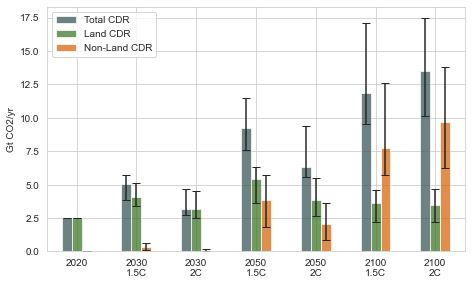

In [15]:
color = {
    'Land CDR': '#33701a',
    'Non-Land CDR': '#d55e00',
    'Total CDR': 'darkslategrey',
}
size = 3
fig, ax = plt.subplots(figsize=(2.5 * size, 1.5 * size))
pdata.index = pdata.index.map(lambda x: '\n'.join(x.split()))
sequestration_plot(
    pdata[::-1], 
    medians=False, stacked=False, order=variables.values(), color=color,
    legend={'loc': 'best'}, ax=ax,
)
#ax.set_title('Carbon Removal Levels', fontsize=16)
ax.set_ylabel('Gt CO2/yr') 
ax.set_xlabel('')

#for i in range(3):
#    ax.axvline(i * 2 + 0.5, c='k', lw=3, alpha=0.5)


for ext in exts:
    fig.savefig(f'./files/fig5_a.{ext}', dpi=1200, bbox_inches='tight')

# Share of CDR

In [16]:
def share_of_cdr_data(
    df,
    numerator,
    denominator,
    categories_to_temp,
    offset=None,
    quantiles=(0.25, 0.5, 0.75),
):
    variables = [denominator, numerator]
    dfs = []
    for cat, temp in categories_to_temp.items():
        data = df.filter(
            variable=variables, region="World", year=range(2020, 2101, 10)
        ).filter(Category=cat)
        if offset:
            data = data.offset(year=offset)
        data = (
            data.divide(
                variables[1],
                variables[0],
                name="Land Share of Total CDR",
                ignore_units="fraction",
            )
            .compute.quantiles(quantiles)
            .rename({"model": {"Quantiles": temp}})
            .timeseries()
        )
        dfs.append(data)
    return pd.concat(dfs)

In [17]:
# fraction of total cdr
total_share = share_of_cdr_data(
    df,
    numerator='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    denominator='AR6 Reanalysis|OSCARv3.2|CDR',
    categories_to_temp={'C1': '1.5C', 'C3': '2C'},
    quantiles=(0.25, 0.5, 0.75)
)
total_share.round(decimals=2)

2020  2030  2040  \
model scenario region variable                unit                         
1.5C  0.25     World  Land Share of Total CDR fraction   1.0  0.88  0.59   
      0.5      World  Land Share of Total CDR fraction   1.0  0.94  0.74   
      0.75     World  Land Share of Total CDR fraction   1.0  0.98  0.91   
2C    0.25     World  Land Share of Total CDR fraction   1.0  0.96  0.72   
      0.5      World  Land Share of Total CDR fraction   1.0  0.99  0.89   
      0.75     World  Land Share of Total CDR fraction   1.0  1.00  0.96   

                                                        2050  2060  2070  \
model scenario region variable                unit                         
1.5C  0.25     World  Land Share of Total CDR fraction  0.44  0.33  0.28   
      0.5      World  Land Share of Total CDR fraction  0.60  0.51  0.43   
      0.75     World  Land Share of Total CDR fraction  0.77  0.66  0.55   
2C    0.25     World  Land Share of Total CDR fraction  0.44  0.28  0.25   
      0.5      World  Land Share of Total CDR fraction  0.73  0.50  0.40   
      0.75     World  Land Share of Total CDR fraction  0.88  0.72  0.56   

                                                        2080  2090  2100  
model scenario region variable                unit                        
1.5C  0.25     World  Land Share of Total CDR fraction  0.25  0.23  0.21  
      0.5      World  Land Share of Total CDR fraction  0.37  0.34  0.30  
      0.75     World  Land Share of Total CDR fraction  0.47  0.43  0.42  
2C    0.25     World  Land Share of Total CDR fraction  0.23  0.21  0.19  
      0.5      World  Land Share of Total CDR fraction  0.33  0.30  0.29  
      0.75     World  Land Share of Total CDR fraction  0.46  0.40  0.35

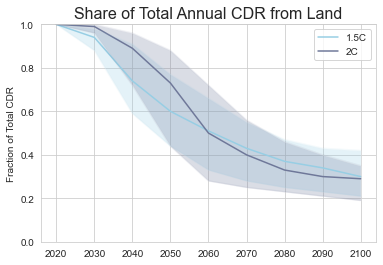

In [18]:
fig, ax = plt.subplots()
data = pyam.IamDataFrame(total_share.round(decimals=2))
(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=True)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
ax.set_title('Share of Total Annual CDR from Land', fontsize=16)
ax.set_ylabel('Fraction of Total CDR')
ax.set_xlabel('')
ax.set_ylim([-0.0, 1.0])

for ext in exts:
    fig.savefig(f'./files/fig_5b.{ext}', dpi=1200, bbox_inches='tight')

# Bar Plots of Removals

## Make Data

In [19]:
# Confirm there are no C1-C3 in current policies
meta = df.meta.copy()
meta.query("Policy_category_name == 'P1b: Current policies'").Category.unique()

array(['C7', 'C6', 'C5'], dtype=object)

In [20]:
df.add(a='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', b='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect', name='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land', ignore_units=True, append=True)

In [21]:
variable_rename = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Total Land Removals',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Land CDR (Direct)',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Indirect Removals',
}
variables = list(variable_rename.values())
data = df.rename(variable=variable_rename).filter(region='World', variable=variables, year=[2020, 2030, 2050])

In [22]:
data = data.offset(year=2020).filter(year=2020, keep=False)

In [23]:
def make_removal_plot_data(df, variables, temps, years=[2030, 2050]):
    # pyam version of quantile data
    data = pyam.concat([
        (
            df
            .filter(region='World', variable=variable)
            .filter(Temperature=temp)
            .compute.quantiles((0.25, 0.5, 0.75))
            .rename(model={'Quantiles': temp})
        ) for temp, variable in itertools.product(temps, variables)
    ])
    
    # data ready for plotting
    pdata = (
        data
        .filter(year=years)
        .as_pandas(meta_cols=False)
        .drop(columns=['region', 'unit'])
        .set_index(['year', 'model', 'scenario', 'variable'])
        ['value']
        .unstack(['scenario', 'variable'])
        / 1e3
    )
    pdata = pdata.reindex(index=pdata.index[::-1]) # reverse ordering so plots are in correct order
    return data, pdata



## Make Plots

In [24]:
order = ['1.5C', '2C', 'Current Policies']

color_removals = {
    'Land CDR (Direct)': '#33701a',
    'Indirect Removals': 'indigo',
    'Total Land Removals': '#a3176d',
}

In [25]:

from matplotlib.transforms import Affine2D

def removal_plot(
    pdata, order=None, hlines=True, stacked=True, 
    climate_error=None,
    cmap='PiYG', ax=None, legend=pyam.plotting.OUTSIDE_LEGEND['bottom']
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    if order:
        pdata = pdata.loc[order]    
    base, mins, maxs = pdata['0.5'], pdata['0.25'], pdata['0.75']
    errors = [[base[c] - mins[c], maxs[c] - base[c]] for c in base.columns]
    
    trans1 = Affine2D().translate(-0.025, 0.0) + ax.transData
    trans2 = Affine2D().translate(+0.025, 0.0) + ax.transData
    
    if hlines:
        for (idx, hline) in base['Total Land Removals'].items():
            ax.axhline(hline, c=pyam.plotting.PYAM_COLORS[color_map[idx]], label=idx, ls='--', alpha=0.75)   
    
    error_kw = dict(ecolor="k", transform=trans1, alpha=0.75, label='Scenario Uncertainty') if climate_error is not None else {}
    base.plot.bar(
        yerr=errors, capsize=4, rot=0, stacked=stacked, ax=ax, 
        color=color_removals, alpha=0.7, legend=False,
        error_kw=error_kw,
    )


    
    if climate_error is not None:
        if order:
            climate_error = climate_error.loc[order]
        base, cmins, cmaxs = pdata['0.5'], climate_error[0.25], climate_error[0.75]
        cerrors = [[base[c] - cmins[c], cmaxs[c] - base[c]] for c in base.columns]
        base.plot.bar(
            yerr=cerrors, capsize=4, rot=0, stacked=stacked, ax=ax, 
            color=color_removals, alpha=0.0, legend=False, 
            error_kw=dict(ecolor="darkgrey", transform=trans2, label='Carbon Cycle Uncertainty'),
        )
    
    if legend:
        ax.legend(**legend)
    return ax

In [26]:
def make_error(fig_name):
    import scipy.stats as sps

    error = pd.read_excel(data_path / 'LUC_uncertainty_AR6_reanalysis.xlsx', sheet_name=fig_name)

    for pct in [0.25, 0.75]:
        error[pct] = error.apply(lambda row: sps.norm(loc=row['mean'], scale=row['std']).ppf(pct), axis=1)

    climate_error = error.rename(columns={'Category': 'model'}).set_index(['model', 'Type']).unstack('Type')
    
    return climate_error

In [27]:
_data, pdata = make_removal_plot_data(data, variables, list(categories_to_temp.values()), years=[2030, 2050])

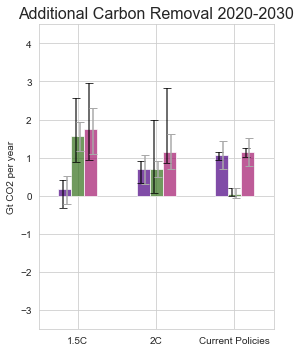

In [28]:
year = 2030
climate_error = make_error('Fig4C')
size = 4
fig, ax = plt.subplots(figsize=(1 * size, 1.25 * size))
legend = False
removal_plot(
    pdata.loc[year], stacked=False, hlines=False, 
    climate_error=climate_error, 
    ax=ax, order=order, legend=legend
)


ax.set_title(f'Additional Carbon Removal 2020-{year}', fontsize=16)
ax.set_ylabel('Gt CO2 per year') 
ax.set_xlabel('')
ax.set_ylim(-3.5, 4.5)

plt.tight_layout()
for ext in exts:
    fig.savefig(f'./files/fig5_c.{ext}', dpi=1200, bbox_inches='tight')

In [29]:
def construct_removal_legend(ax, idxs, legend):
    h, l = ax.get_legend_handles_labels()
    handles = [h[i] for i in idxs]
    labels = [l[i] for i in idxs]
    ax.legend(handles, labels, **legend)

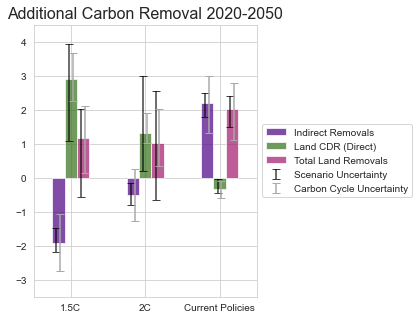

In [30]:
year = 2050
climate_error = make_error('Fig4D')

size = 4
fig, ax = plt.subplots(figsize=(1 * size, 1.25 * size))
legend = pyam.plotting.OUTSIDE_LEGEND['right'].copy()
legend.update(ncol=1)
removal_plot(
    pdata.loc[year], stacked=False, hlines=False, 
    climate_error=climate_error, 
    ax=ax, order=order, legend=legend
)
ax.set_title(f'Additional Carbon Removal 2020-{year}', fontsize=16)
ax.set_xlabel('')
ax.set_ylim(-3.5, 4.5)

## This block should be commented/uncommented to get adobe-ready versions
idxs = [1, 3, 5, 4, 6]
construct_removal_legend(ax, idxs, legend)

for ext in exts:
    fig.savefig(f'./files/fig5_d.{ext}', dpi=1200, bbox_inches='tight')

# SI Plots

## Removal levels by land

In [31]:
variables = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Land CDR (Direct)',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Indirect Removals',
}
hist = [2015, 2020]
hist = [2020]
future = [2030, 2050]
future = [2030, 2050, 2100]
data, pdata = make_sequestration_plot_data(
    df.filter(variable=variables.keys(), region='World').rename({'variable': variables}), 
    variables.values(), 
    {'C1': '1.5C', 'C3': '2C'}, years=hist + future
)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

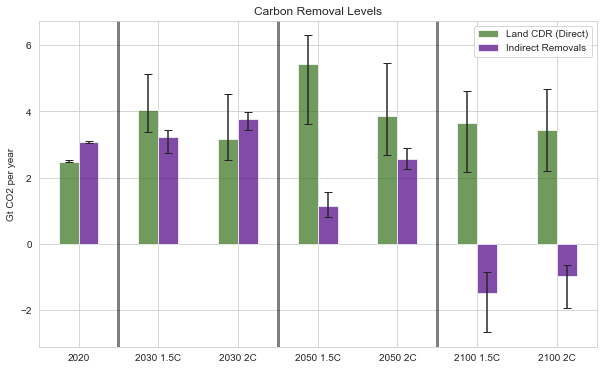

In [32]:
size = 4
fig, ax = plt.subplots(figsize=(2.5 * size, 1.5 * size))
sequestration_plot(
    pdata[::-1], 
    medians=False, stacked=False, order=variables.values(), 
    color={'Land CDR (Direct)': '#33701a', 'Indirect Removals': 'indigo'},
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_ylabel('Gt CO2 per year') 
ax.set_xlabel('')

for i in range(3):
    ax.axvline(i * 2 + 0.5, c='k', lw=3, alpha=0.5)
#ax.set_xlim(0, 18)
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])
for ext in exts:
    fig.savefig(f'./files/figsi4a.{ext}', dpi=1200, bbox_inches='tight')

In [33]:
pdata/ pdata.loc['2020']

scenario               0.25                                 0.5  \
variable  Indirect Removals Land CDR (Direct) Indirect Removals   
index                                                             
2100 2C           -0.637839          0.889908         -0.314799   
2100 1.5C         -0.871055          0.879604         -0.483882   
2050 2C            0.745804          1.083839          0.829782   
2050 1.5C          0.273017          1.466897          0.372934   
2030 2C            1.128086          1.026133          1.229089   
2030 1.5C          0.904038          1.367713          1.049510   
2020               1.000000          1.000000          1.000000   

scenario                                 0.75                    
variable  Land CDR (Direct) Indirect Removals Land CDR (Direct)  
index                                                            
2100 2C            1.386553         -0.200401          1.847507  
2100 1.5C          1.465213         -0.268217          1.833274  
2050 2C            1.554694          0.930474          2.164417  
2050 1.5C          2.188953          0.502465          2.490735  
2030 2C            1.275939          1.281603          1.789481  
2030 1.5C          1.629532          1.107823          2.032962  
2020               1.000000          1.000000          1.000000

## Cumulative CDR

In [34]:
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
data, pdata = make_sequestration_plot_data(df.filter(region='World'), variables, {'C1': '1.5C', 'C3': '2C'}, years=future)

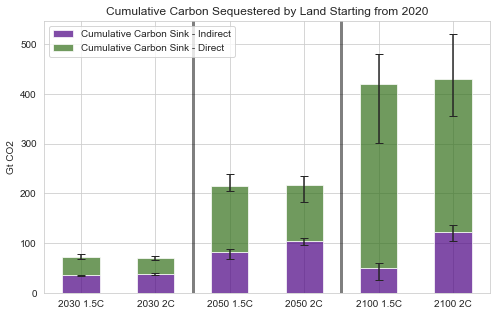

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sequestration_plot(
    pdata[::-1], order=variables, medians=False,
    color={'Cumulative Carbon Sink - Direct': '#33701a', 'Cumulative Carbon Sink - Indirect': 'indigo'},
    legend={'loc': 'best'}, ax=ax
)
ax.set_title('Cumulative Carbon Sequestered by Land Starting from 2020')
ax.set_ylabel('Gt CO2')
ax.set_xlabel('')
for i in range(1, 3):
    ax.axvline(i * 2 - 0.5, c='k', lw=3, alpha=0.5)
for ext in exts:
    fig.savefig(f'./files/figsi4b.{ext}', dpi=1200, bbox_inches='tight')

In [36]:
pdata['0.5']

variable,Cumulative Carbon Sink - Direct,Cumulative Carbon Sink - Indirect
index,,
2100 2C,308.000642,121.384628
2100 1.5C,368.369799,50.441567
2050 2C,113.314394,103.862275
2050 1.5C,132.976731,81.201525
2030 2C,31.195124,38.079931
2030 1.5C,35.941523,35.414730


In [37]:
133 / 113 # ~20% more

1.176991150442478

In [38]:
81 / 103 # ~20% less

0.7864077669902912